In [19]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
from feature_set_v2 import MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier


In [20]:
# import importlib
# import feature_25 
# importlib.reload(feature_25)


In [21]:
def rolling_time_series_cv_sjm_long_short_optimized(
    lambda_values,
    kappa_values,
    X_train,
    X_val,
    factor_returns_train,
    factor_returns_val,
    market_returns_train,
    market_returns_val,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Optimized CV function that evaluates hyperparameters on pre-defined train/val sets.
    Returns the best hyperparameters and associated model.
    """
    # Ensure DataFrames have aligned indices
    train_common_index = X_train.index.intersection(factor_returns_train.index).intersection(market_returns_train.index)
    val_common_index = X_val.index.intersection(factor_returns_val.index).intersection(market_returns_val.index)
    
    if len(train_common_index) == 0 or len(val_common_index) == 0:
        raise ValueError("No common dates between X, factor_returns, and market_returns")
    
    # Apply common index
    X_train = X_train.loc[train_common_index]
    factor_returns_train = factor_returns_train.loc[train_common_index]
    market_returns_train = market_returns_train.loc[train_common_index]
    
    X_val = X_val.loc[val_common_index]
    factor_returns_val = factor_returns_val.loc[val_common_index]
    market_returns_val = market_returns_val.loc[val_common_index]
    
    # Generate active returns
    active_train = factor_returns_train - market_returns_train
    active_val = factor_returns_val - market_returns_val
    
    print(f"Training data: {X_train.index[0]} to {X_train.index[-1]} ({len(X_train)} days)")
    print(f"Validation data: {X_val.index[0]} to {X_val.index[-1]} ({len(X_val)} days)")
    
    # Standardize and clip the data
    clipper = DataClipperStd(mul=3.)
    X_train_clipped = clipper.fit_transform(X_train)
    X_val_clipped = clipper.transform(X_val)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_clipped),
        index=X_train_clipped.index,
        columns=X_train_clipped.columns
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_clipped),
        index=X_val_clipped.index,
        columns=X_val_clipped.columns
    )
    
    # Grid search over hyperparameters
    best_sharpe = -np.inf
    best_lambda = None
    best_kappa = None
    best_model = None
    results = []
    
    for lam in lambda_values:
        for kappa in kappa_values:
            max_feats = int(kappa**2)
            
            try:
                # Fit model
                model = SparseJumpModel(
                    n_components=2,
                    max_feats=max_feats,
                    jump_penalty=lam,
                    cont=False,
                    max_iter=30
                )
                model.fit(X_train_scaled, ret_ser=active_train, sort_by="cumret")
                
                # Calculate regime counts for diagnostic purposes
                train_states = model.predict(X_train_scaled)
                regime_counts = np.bincount(train_states, minlength=2)
                
                # Skip if model didn't find both regimes or has NaN returns
                if regime_counts[0] == 0 or regime_counts[1] == 0 or np.isnan(model.ret_).any():
                    print(f"Skipping λ={lam}, κ={kappa}: Invalid regime distribution {regime_counts} or NaN returns")
                    results.append(-np.inf)
                    continue
                
                # Calculate positions and returns on validation set
                val_states = model.predict_online(X_val_scaled)
                val_regime_counts = np.bincount(val_states, minlength=2)
                
                # Define position function
                def position_from_expected_return(ann_ret, threshold=annual_threshold):
                    if ann_ret > threshold: 
                        return 1.0
                    elif ann_ret < -threshold: 
                        return -1.0
                    else: 
                        return ann_ret / threshold

                # Map regime returns to expected annual returns
                state_avg_daily_active_ret = model.ret_
                state_to_expected = {
                    st: state_avg_daily_active_ret[st] * 252 for st in range(len(state_avg_daily_active_ret))
                }
                
                # Calculate strategy returns with day-lag logic
                strategy_ret = np.zeros(len(val_states))
                prev_position = 0.0
                
                for t in range(len(val_states)):
                    st = val_states.iloc[t]
                    # Calculate PnL based on previous day's position
                    daily_pnl = prev_position * active_val.iloc[t]
                    
                    # Calculate new position based on current day's state
                    new_position = position_from_expected_return(state_to_expected.get(st, 0.0))
                    
                    # Calculate trading costs
                    turnover = abs(new_position - prev_position)
                    cost = turnover * cost_per_100pct
                    
                    # Record strategy return
                    strategy_ret[t] = daily_pnl - cost
                    
                    # Update position for next day
                    prev_position = new_position
                
                # Calculate Sharpe ratio
                avg_ret = np.mean(strategy_ret)
                std_ret = np.std(strategy_ret, ddof=1)
                
                # Skip if std is zero
                if std_ret == 0:
                    print(f"Skipping λ={lam}, κ={kappa}: Zero standard deviation in strategy returns")
                    results.append(-np.inf)
                    continue
                    
                val_sharpe = (avg_ret/std_ret) * np.sqrt(252)
                results.append(val_sharpe)
                
                # Print diagnostics
                print(f"λ={lam:.2f}, κ={kappa:.2f}, Sharpe={val_sharpe:.4f}, "
                      f"Train states={regime_counts}, Val states={val_regime_counts}")
                
                # Update best if improved
                if val_sharpe > best_sharpe:
                    best_sharpe = val_sharpe
                    best_lambda = lam
                    best_kappa = kappa
                    best_model = model
                    
            except Exception as e:
                print(f"Error with λ={lam}, κ={kappa}: {e}")
                results.append(-np.inf)
    
    if best_model is None:
        raise ValueError("No valid model found during hyperparameter search")
        
    print(f"Best params: λ={best_lambda:.2f}, κ={best_kappa:.2f}, Sharpe={best_sharpe:.4f}")
    
    # Reshape results for plotting
    results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
    
    return {
        "best_lambda": best_lambda,
        "best_kappa": best_kappa,
        "best_sharpe": best_sharpe,
        "best_model": best_model,
        "results_array": results_array
    }

In [22]:
###############################################################################
# 1) HELPER: EWMA Covariance
###############################################################################
def ewm_covariance(returns: pd.DataFrame, halflife=126, min_periods=1) -> pd.DataFrame:
    """
    Compute an exponentially weighted covariance matrix over all data in 'returns'.
    The half-life is 126 days, meaning weights decay by 50% every 126 days.
    We then select the final NxN slice from the multi-index result.
    """
    ewm_cov = returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).cov()
    if len(returns) == 0:
        # Return an empty DataFrame if no data
        return pd.DataFrame()
    last_date = returns.index[-1]
    df_slice = ewm_cov.loc[last_date]  # shape (N, N)
    df_slice.index.name = None
    return df_slice

In [23]:
###############################################################################
# 2) HELPER: Rolling + Expanding Black–Litterman
###############################################################################
def run_bl_portfolio_pyopt_expanding(
    factor_dict,
    returns_df,
    test_index,
    tau=0.05,
    delta=2.5
):
    """
    An expanding-window Black–Litterman procedure:
    - For each date t in test_index, we take all historical data up to t-1 to compute:
       (a) an EWMA covariance (with half-life=126)
       (b) a BL prior using pi="equal"  (i.e. all assets get equal baseline expected return)
       (c) factor-based relative views: factor vs Market => P, Q
    - Then we get posterior (bl_returns, bl_cov).
    - Then run a standard Efficient Frontier (max_sharpe).
    - We store the resulting weights for day t+1 (one-day lag).
    """
    assets = list(returns_df.columns)   # e.g. [factor1, factor2, ..., Market]
    factors = list(factor_dict.keys())  # e.g. [factor1, factor2, ...]
    weights_df = pd.DataFrame(index=test_index, columns=assets, dtype=float)

    test_dates = list(test_index)

    for i, t in enumerate(test_dates):
        # 1) Expand up to day t-1
        window_end_idx = returns_df.index.get_loc(t)
        if window_end_idx == 0:
            # No prior data => skip
            continue
        expanding_slice = returns_df.iloc[:window_end_idx]

        # 2) Compute the EWMA covariance
        cov_matrix = ewm_covariance(expanding_slice, halflife=126, min_periods=60)
        if cov_matrix.empty or cov_matrix.isna().any().any():
            # If invalid, skip
            continue

        # 3) Construct the (P, Q) for factor vs Market
        #    Q is the list of "annual active returns" for each factor's bull/bear regime
        P_matrix = []
        Q_values = []
        for fac in factors:
            # Which regime do we see for factor "fac" at day t?
            st = factor_dict[fac]['states'].loc[t]
            daily_active_ret = factor_dict[fac]['regime_returns'][st]  # daily factor active
            annual_active_ret = daily_active_ret * 252
            Q_values.append(annual_active_ret)

            # row is +1 on factor, -1 on 'Market'
            row = [0]*len(assets)
            row[assets.index(fac)] = 1
            row[assets.index("Market")] = -1
            P_matrix.append(row)

        P = pd.DataFrame(P_matrix, columns=assets)
        Q = pd.Series(Q_values)

        # 4) Build the Black–Litterman model
        #    We'll say pi="equal" so that each asset has the same baseline prior
        #    Then we incorporate the relative views in (P, Q).
        #    tau=0.05 is a typical default.
        try:
            bl = BlackLittermanModel(
                cov_matrix=cov_matrix,
                pi="equal",
                P=P,
                Q=Q,
                tau=tau,
                delta=delta,
                # no "omega" => default is Proportional to var of view portfolio
            )
        except Exception as e:
            print(f"BL Model error on day {t}: {e}")
            continue

        # 5) Retrieve posterior returns & covariance
        mu_bl = bl.bl_returns()
        cov_bl = bl.bl_cov()  # posterior covariance

        # 6) Mean-variance optimization
        ef = EfficientFrontier(mu_bl, cov_bl, weight_bounds=(-0, 1))
        try:
            ef.max_sharpe()  # or ef.min_volatility() etc.
        except Exception as e:
            print(f"Optimization error on day {t}: {e}")
            continue

        # 7) Store weights for day t+1 (one-day lag)
        w_series = pd.Series(ef.clean_weights(), name=t)
        if i < len(test_dates) - 1:
            rebalance_day = test_dates[i+1]
            weights_df.loc[rebalance_day] = w_series
        else:
            weights_df.loc[t] = w_series

    return weights_df


In [24]:
# ---------------------------------------------------------------------
# Sharpe Ratio
# ---------------------------------------------------------------------
def annualized_sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

In [25]:
# # manual build of best_hyperparams dict for BL model if we don't want to run the SJM CV again
# best_hyperparams = {
#     "IWF": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.0
#     },
#     "MTUM": {
#         "best_lambda": 239.5026619987486,
#         "best_kappa": 2.0
#     },
#     "QUAL": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.44948974278
#     },
#     "SIZE": {
#         "best_lambda": 49.72235891449993,
#         "best_kappa": 3.46410161514
#     },
#     "USMV": {
#         "best_lambda": 751.3842180360134,
#         "best_kappa": 2.44948974278
#     },
#     "VLUE": {
#         "best_lambda": 57.36152510448679,
#         "best_kappa": 2
#     },
# }


In [29]:
# %%
# Modified implementation of rolling time series CV and trading process

def rolling_time_series_cv_sjm_long_short_optimized(
    lambda_values,
    kappa_values,
    X_train,
    X_val,
    factor_returns_train,
    factor_returns_val,
    market_returns_train,
    market_returns_val,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Optimized CV function that evaluates hyperparameters on pre-defined train/val sets.
    Returns the best hyperparameters and associated model.
    """
    # Ensure DataFrames have aligned indices
    train_common_index = X_train.index.intersection(factor_returns_train.index).intersection(market_returns_train.index)
    val_common_index = X_val.index.intersection(factor_returns_val.index).intersection(market_returns_val.index)
    
    if len(train_common_index) == 0 or len(val_common_index) == 0:
        raise ValueError("No common dates between X, factor_returns, and market_returns")
    
    # Apply common index
    X_train = X_train.loc[train_common_index]
    factor_returns_train = factor_returns_train.loc[train_common_index]
    market_returns_train = market_returns_train.loc[train_common_index]
    
    X_val = X_val.loc[val_common_index]
    factor_returns_val = factor_returns_val.loc[val_common_index]
    market_returns_val = market_returns_val.loc[val_common_index]
    
    # Generate active returns
    active_train = factor_returns_train - market_returns_train
    active_val = factor_returns_val - market_returns_val
    
    print(f"Training data: {X_train.index[0]} to {X_train.index[-1]} ({len(X_train)} days)")
    print(f"Validation data: {X_val.index[0]} to {X_val.index[-1]} ({len(X_val)} days)")
    
    # Standardize and clip the data
    clipper = DataClipperStd(mul=3.)
    X_train_clipped = clipper.fit_transform(X_train)
    X_val_clipped = clipper.transform(X_val)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_clipped),
        index=X_train_clipped.index,
        columns=X_train_clipped.columns
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_clipped),
        index=X_val_clipped.index,
        columns=X_val_clipped.columns
    )
    
    # Grid search over hyperparameters
    best_sharpe = -np.inf
    best_lambda = None
    best_kappa = None
    best_model = None
    results = []
    
    for lam in lambda_values:
        for kappa in kappa_values:
            max_feats = int(kappa**2)
            
            try:
                # Fit model
                model = SparseJumpModel(
                    n_components=2,
                    max_feats=max_feats,
                    jump_penalty=lam,
                    cont=False,
                    max_iter=30
                )
                model.fit(X_train_scaled, ret_ser=active_train, sort_by="cumret")
                
                # Calculate regime counts for diagnostic purposes
                train_states = model.predict(X_train_scaled)
                regime_counts = np.bincount(train_states, minlength=2)
                
                # Skip if model didn't find both regimes or has NaN returns
                if regime_counts[0] == 0 or regime_counts[1] == 0 or np.isnan(model.ret_).any():
                    print(f"Skipping λ={lam}, κ={kappa}: Invalid regime distribution {regime_counts} or NaN returns")
                    results.append(-np.inf)
                    continue
                
                # Calculate positions and returns on validation set
                val_states = model.predict_online(X_val_scaled)
                val_regime_counts = np.bincount(val_states, minlength=2)
                
                # Define position function
                def position_from_expected_return(ann_ret, threshold=annual_threshold):
                    if ann_ret > threshold: 
                        return 1.0
                    elif ann_ret < -threshold: 
                        return -1.0
                    else: 
                        return ann_ret / threshold

                # Map regime returns to expected annual returns
                state_avg_daily_active_ret = model.ret_
                state_to_expected = {
                    st: state_avg_daily_active_ret[st] * 252 for st in range(len(state_avg_daily_active_ret))
                }
                
                # Calculate strategy returns with day-lag logic
                strategy_ret = np.zeros(len(val_states))
                prev_position = 0.0
                
                for t in range(len(val_states)):
                    st = val_states.iloc[t]
                    # Calculate PnL based on previous day's position
                    daily_pnl = prev_position * active_val.iloc[t]
                    
                    # Calculate new position based on current day's state
                    new_position = position_from_expected_return(state_to_expected.get(st, 0.0))
                    
                    # Calculate trading costs
                    turnover = abs(new_position - prev_position)
                    cost = turnover * cost_per_100pct
                    
                    # Record strategy return
                    strategy_ret[t] = daily_pnl - cost
                    
                    # Update position for next day
                    prev_position = new_position
                
                # Calculate Sharpe ratio
                avg_ret = np.mean(strategy_ret)
                std_ret = np.std(strategy_ret, ddof=1)
                
                # Skip if std is zero
                if std_ret == 0:
                    print(f"Skipping λ={lam}, κ={kappa}: Zero standard deviation in strategy returns")
                    results.append(-np.inf)
                    continue
                    
                val_sharpe = (avg_ret/std_ret) * np.sqrt(252)
                results.append(val_sharpe)
                
                # # Print diagnostics that show lambda, sharpe, and regimes for the current fold
                # print(f"λ={lam:.2f}, κ={kappa:.2f}, Sharpe={val_sharpe:.4f}, "
                #       f"Train states={regime_counts}, Val states={val_regime_counts}")
                
                # Update best if improved
                if val_sharpe > best_sharpe:
                    best_sharpe = val_sharpe
                    best_lambda = lam
                    best_kappa = kappa
                    best_model = model
                    
            except Exception as e:
                print(f"Error with λ={lam}, κ={kappa}: {e}")
                results.append(-np.inf)
    
    if best_model is None:
        raise ValueError("No valid model found during hyperparameter search")
        
    print(f"Best params: λ={best_lambda:.2f}, κ={best_kappa:.2f}, Sharpe={best_sharpe:.4f}")
    
    # Reshape results for plotting
    results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
    
    return {
        "best_lambda": best_lambda,
        "best_kappa": best_kappa,
        "best_sharpe": best_sharpe,
        "best_model": best_model,
        "results_array": results_array
    }


# Modified main function for more efficient processing
if __name__ == "__main__":
    ############################################################################
    # 0) Set parameters
    ############################################################################
    # We define how often to re-fit and re-cross-validate:
    REFIT_FREQ = "ME"  # Monthly refit
    RECROSS_VAL_FREQ = "6ME"  # Every 6 months recross-validation
    
    # Training window configuration
    MIN_TRAINING_YEARS = 8  # Minimum 8 years of training data
    MAX_TRAINING_YEARS = 12  # Maximum 12 years of training data
    VAL_YEARS = 6  # 6-year validation window
    
    # Paths & Tickers
    directory = r"C:\Users\victo\git_new\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "1estimation_index_returns.csv")
    market_file = os.path.join(directory, "1macro_data.csv")
    factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]

    # Date boundaries
    train_start = "2002-05-31"
    test_start = "2017-01-01"

    # Cross-validation settings
    lambda_values = np.linspace(30, 400, 10)  # For grid search
    
    ############################################################################
    # 1) Load full data for all factors & market
    ############################################################################
    # We'll store each factor's entire X and returns in a dict for easy access
    factor_data_dict = {}
    factor_returns_list = []
    for fac in factors:
        print(f"\nLoading data for factor {fac}")
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=fac
        ).load()
        common_idx = (
            data.X.index
            .intersection(data.ret_ser.index)
            .intersection(data.market_ser.index)
        )

        # Full factor data
        X_full = data.X.loc[common_idx]
        fac_ret_full = data.ret_ser.loc[common_idx]
        mkt_ret_full = data.market_ser.loc[common_idx]
        active_ret = fac_ret_full - mkt_ret_full ################################################################################## we can access with attribute

        factor_data_dict[fac] = {
            "X": X_full,
            "fac_ret": fac_ret_full,
            "mkt_ret": mkt_ret_full,
            "active_ret": active_ret
        }
        factor_returns_list.append(fac_ret_full)

    # We'll store the last loaded "mkt_ret_full" as "all_market_ret"
    all_market_ret = mkt_ret_full

    # Combine factor returns + market into a single DF
    full_factors_df = pd.concat(factor_returns_list, axis=1).dropna()  # T x 6
    full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
    full_df.columns = factors + ["Market"]

    # Our "test_index" is from test_start onward
    test_slice = filter_date_range(full_df, start_date=test_start)
    test_index = test_slice.index.sort_values()

    # Define refit and re-cross-validation boundaries
    refit_boundaries = (
        test_index.to_series()
        .resample(REFIT_FREQ)
        .last()
        .dropna()
    )
    
    recross_val_boundaries = (
        test_index.to_series()
        .resample(RECROSS_VAL_FREQ)
        .last()
        .dropna()
    )

    # Helper function to get appropriate training and validation windows
def get_train_val_windows(current_date, full_data, 
                         min_train_years=MIN_TRAINING_YEARS,
                         max_train_years=MAX_TRAINING_YEARS, 
                         val_years=VAL_YEARS,
                         train_start_date=train_start):
    """
    Get training and validation data windows based on configuration.
    
    Fixed to properly implement expanding window concept while respecting min/max constraints.
    """
    # Convert date strings to datetime if needed
    if isinstance(train_start_date, str):
        train_start_date = pd.to_datetime(train_start_date)
    if isinstance(current_date, str):
        current_date = pd.to_datetime(current_date)
        
    # Validation window ends at current_date
    val_end = current_date
    # Validation window starts val_years before end
    val_start = val_end - pd.DateOffset(years=val_years)
    
    # Check if we have enough data for validation
    full_index = full_data.index
    future_dates = full_index[full_index > val_start]
    
    # If not enough future data, shorten validation window
    if len(future_dates) < 252 * min_val_years:  # Assuming ~252 trading days per year
        # Not enough future data for minimum validation window
        return None, None, None, None
    
    if future_dates[-1] < val_end:
        # Adjust val_end to available data
        val_end = future_dates[-1]
        # Recalculate val_start only if resulting window is too short
        potential_val_start = val_end - pd.DateOffset(years=val_years)
        if potential_val_start > val_start:
            # Keep original val_start for a shorter window
            pass
        else:
            # Use the recalculated start
            val_start = potential_val_start
    
    # Training window ends right before validation window
    train_end = val_start - pd.DateOffset(days=1)
    
    # Calculate training window start
    # The key change: First try to use the min_train_years constraint
    train_start = train_end - pd.DateOffset(years=min_train_years)
    
    # Ensure we don't go before the train_start_date
    train_start = max(train_start_date, train_start)
    
    # Apply max_train_years constraint if needed
    earliest_allowed = train_end - pd.DateOffset(years=max_train_years)
    if train_start < earliest_allowed:
        train_start = earliest_allowed
    
    # Filter to actual available dates
    full_index = full_data.index
    
    # Find actual train boundaries
    train_dates = full_index[
        (full_index >= train_start) & 
        (full_index <= train_end)
    ]
    
    # Find actual validation boundaries
    val_dates = full_index[
        (full_index >= val_start) & 
        (full_index <= val_end)
    ]
    
    if len(train_dates) == 0 or len(val_dates) == 0:
        raise ValueError(f"Insufficient data in the requested windows: "
                        f"Train [{train_start} to {train_end}], "
                        f"Val [{val_start} to {val_end}]")
        
    # Return the actual boundaries
    return train_dates[0], train_dates[-1], val_dates[0], val_dates[-1]

    ############################################################################
    # 2) Main Trading Loop with Periodic Re-Cross-Validation
    ############################################################################
    # Tracking variables
    best_hyperparams = {fac: {"best_lambda": None, "best_kappa": None} for fac in factors}
    all_daily_states = {fac: pd.Series(dtype=float) for fac in factors}
    all_daily_weights = []
    all_daily_rets = []
    hyperparameter_history = {fac: [] for fac in factors}
    training_window_history = []
    validation_window_history = []
    
    # Process each cross-validation period
    for i in range(len(recross_val_boundaries)):
        cv_date = recross_val_boundaries.iloc[i]
        print(f"\n{'='*80}")
        print(f"CROSS-VALIDATION PERIOD: {cv_date}")
        print(f"{'='*80}")
        
        for factor_name in factors:
            print(f"\nProcessing factor {factor_name}")
            
            # Get data for this factor
            data = factor_data_dict[factor_name]
            X = data["X"]
            factor_returns = data["fac_ret"]
            market_returns = data["mkt_ret"]
            
            # Get train/val windows for this CV period
            train_start, train_end, val_start, val_end = get_train_val_windows(
                cv_date, X,
                min_train_years=MIN_TRAINING_YEARS,
                max_train_years=MAX_TRAINING_YEARS,
                val_years=VAL_YEARS,
                train_start_date=train_start
            )
            
            # Extract train/val data
            X_train = filter_date_range(X, start_date=train_start, end_date=train_end)
            X_val = filter_date_range(X, start_date=val_start, end_date=val_end)
            
            factor_returns_train = filter_date_range(factor_returns, start_date=train_start, end_date=train_end)
            factor_returns_val = filter_date_range(factor_returns, start_date=val_start, end_date=val_end)
            
            market_returns_train = filter_date_range(market_returns, start_date=train_start, end_date=train_end)
            market_returns_val = filter_date_range(market_returns, start_date=val_start, end_date=val_end)
            
            # Track window sizes
            training_years = (train_end - train_start).days / 365.25
            validation_years = (val_end - val_start).days / 365.25
            
            print(f"Training: {train_start} to {train_end} ({training_years:.2f} years)")
            print(f"Validation: {val_start} to {val_end} ({validation_years:.2f} years)")
            
            # Add to history
            training_window_history.append({
                "date": cv_date,
                "factor": factor_name,
                "start_date": train_start,
                "end_date": train_end,
                "years": training_years
            })
            
            validation_window_history.append({
                "date": cv_date,
                "factor": factor_name,
                "start_date": val_start,
                "end_date": val_end,
                "years": validation_years
            })
            
            # Define kappa values based on feature count
            kappa_values = np.linspace(2, np.sqrt(X_train.shape[1]), 3)
            
            # Run cross-validation to find best hyperparameters
            cv_results = rolling_time_series_cv_sjm_long_short_optimized(
                lambda_values=lambda_values,
                kappa_values=kappa_values,
                X_train=X_train,
                X_val=X_val,
                factor_returns_train=factor_returns_train,
                factor_returns_val=factor_returns_val,
                market_returns_train=market_returns_train,
                market_returns_val=market_returns_val
            )
            
            # Store previous hyperparameters for comparison
            old_lambda = best_hyperparams[factor_name].get("best_lambda")
            old_kappa = best_hyperparams[factor_name].get("best_kappa")
            
            # Update hyperparameters
            best_hyperparams[factor_name] = {
                "best_lambda": cv_results["best_lambda"],
                "best_kappa": cv_results["best_kappa"],
                "best_model": cv_results["best_model"]  # Store the model for potential reuse
            }
            
            # Record hyperparameter history
            hyperparameter_history[factor_name].append({
                "date": cv_date,
                "old_lambda": old_lambda,
                "new_lambda": cv_results["best_lambda"],
                "old_kappa": old_kappa,
                "new_kappa": cv_results["best_kappa"],
                "sharpe": cv_results["best_sharpe"]
            })
            
            # Plot results if desired
            plt.figure(figsize=(10, 6))
            for k_idx, kp in enumerate(kappa_values):
                plt.plot(lambda_values, cv_results["results_array"][:, k_idx], 
                         label=f"kappa={kp:.2f}")
            plt.axvline(x=cv_results["best_lambda"], color='r', linestyle='--', alpha=0.5)
            plt.xscale('log')
            plt.xlabel('Lambda')
            plt.ylabel('Validation Sharpe')
            plt.title(f"{factor_name} at {cv_date}: Sharpe vs. Lambda")
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Find which refit periods belong to this CV period
        if i < len(recross_val_boundaries) - 1:
            next_cv_date = recross_val_boundaries.iloc[i + 1]
            refit_mask = (refit_boundaries > cv_date) & (refit_boundaries <= next_cv_date)
        else:
            refit_mask = refit_boundaries > cv_date
            
        refit_dates_in_period = refit_boundaries[refit_mask]
        
        # Process each refit period within this CV period
        for j in range(len(refit_dates_in_period)):
            refit_date = refit_dates_in_period.iloc[j]
            
            # Define the trading period
            if j < len(refit_dates_in_period) - 1:
                next_refit_date = refit_dates_in_period.iloc[j + 1]
            else:
                # For the last refit period, use either next CV period or end of data
                if i < len(recross_val_boundaries) - 1:
                    next_refit_date = recross_val_boundaries.iloc[i + 1]
                else:
                    next_refit_date = test_index[-1]
            
            test_mask = (test_index > refit_date) & (test_index <= next_refit_date)
            test_dates_chunk = test_index[test_mask]
            
            if len(test_dates_chunk) == 0:
                continue
                
            print(f"\nTrading period: {refit_date} to {next_refit_date} ({len(test_dates_chunk)} days)")
            
            # Build factor dict for BL portfolio construction
            factor_dict_chunk = {}
            
            # Process each factor for this refit period
            for fac in factors:
                fac_data = factor_data_dict[fac]
                X = fac_data["X"]
                ret_full = fac_data["fac_ret"]
                mkt_full = fac_data["mkt_ret"]
                active = fac_data["active_ret"]
                
                # Get appropriate training window for this refit date
                train_start, train_end = get_train_val_windows(
                    refit_date, X,
                    min_train_years=MIN_TRAINING_YEARS,
                    max_train_years=MAX_TRAINING_YEARS,
                    val_years=0,  # No validation window needed for refit
                    train_start_date=train_start
                )[:2]  # Take only train_start and train_end
                
                # Get training data
                X_train = filter_date_range(X, start_date=train_start, end_date=train_end)
                active_train = filter_date_range(active, start_date=train_start, end_date=train_end)
                
                # Process training data
                clipper = DataClipperStd(mul=3.0)
                X_train_clip = clipper.fit_transform(X_train)
                
                scaler = StandardScaler()
                X_train_scaled = pd.DataFrame(
                    scaler.fit_transform(X_train_clip),
                    index=X_train_clip.index,
                    columns=X_train_clip.columns
                )
                
                # Get hyperparameters for this factor
                lam = best_hyperparams[fac]["best_lambda"]
                kp = best_hyperparams[fac]["best_kappa"]
                max_feats = int(kp**2)
                
                # Fit SJM
                sjm = SparseJumpModel(
                    n_components=2, 
                    max_feats=max_feats, 
                    jump_penalty=lam
                )
                sjm.fit(X_train_scaled, ret_ser=active_train, sort_by="cumret")
                
                # Daily online inference for trading period
                X_test_proc_list = []
                for day in test_dates_chunk:
                    # For online scaling, we use all available history up to the current day
                    X_hist = X.loc[:day]
                    
                    # Clip & scale using all history
                    temp_clipper = DataClipperStd(mul=3.0)
                    X_hist_clip = temp_clipper.fit_transform(X_hist)
                    
                    temp_scaler = StandardScaler()
                    _ = temp_scaler.fit_transform(X_hist_clip)  # Fit on all history
                    
                    # Transform just the current day
                    if day in X.index:
                        X_day = X.loc[[day]]
                        X_day_clip = temp_clipper.transform(X_day)
                        X_day_scaled = temp_scaler.transform(X_day_clip)
                        X_test_proc_list.append(
                            pd.Series(X_day_scaled.flatten(), index=X_day.columns, name=day)
                        )
                
                X_test_scaled = pd.DataFrame(X_test_proc_list).sort_index()
                
                # Predict states
                if not X_test_scaled.empty:
                    states_chunk = sjm.predict_online(X_test_scaled)
                    states_series = pd.Series(states_chunk, index=X_test_scaled.index)
                else:
                    states_series = pd.Series(dtype=float)
                
                # Update global state tracking
                all_daily_states[fac] = pd.concat(
                    [s for s in [all_daily_states[fac], states_series] if not s.empty]
                ).sort_index()
                
                # Store factor info for BL
                factor_dict_chunk[fac] = {
                    "ret": ret_full,
                    "states": states_series,
                    "regime_returns": {
                        0: sjm.ret_[0],
                        1: sjm.ret_[1],
                    },
                }
                
            # Run Black-Litterman portfolio construction
            weights_chunk = run_bl_portfolio_pyopt_expanding(
                factor_dict=factor_dict_chunk,
                returns_df=full_df,
                test_index=test_dates_chunk,
                tau=0.05,
                delta=2.5
            )
            
            # Compute portfolio returns
            daily_factor_rets = full_df.loc[test_dates_chunk, factors]
            portfolio_rets = (weights_chunk * daily_factor_rets).sum(axis=1)
            
            # Store results
            all_daily_weights.append(weights_chunk)
            all_daily_rets.append(portfolio_rets)
    
    ############################################################################
    # 3) Analyze Results and Compare to Benchmarks
    ############################################################################
    if len(all_daily_rets) == 0:
        raise ValueError("No daily returns computed. Check your date ranges or data.")

    all_portfolio_rets = pd.concat(all_daily_rets).sort_index()
    all_weights_df = pd.concat(all_daily_weights).sort_index()
    cumrets = all_portfolio_rets.cumsum()

    # Compare to equal-weight benchmark
    overlap_idx = all_portfolio_rets.index.intersection(full_df.index)
    test_returns_df = full_df.loc[overlap_idx, :]
    ew_bench_rets = test_returns_df.mean(axis=1)
    ew_bench_cum = ew_bench_rets.cumsum()
    
    # Also compute quarterly-rebalanced EW portfolio
    quarterly_ends = test_returns_df.index.to_series().resample("QE").last().dropna()
    n_assets = test_returns_df.shape[1]
    quarterly_ew_rets = pd.Series(index=test_returns_df.index, dtype=float)

    for i in range(len(quarterly_ends) - 1):
        start_q = quarterly_ends.iloc[i]
        end_q = quarterly_ends.iloc[i + 1]
        mask = (test_returns_df.index > start_q) & (test_returns_df.index <= end_q)
        chunk_dates = test_returns_df.index[mask]
        
        w = np.ones(n_assets) / n_assets
        
        for day in chunk_dates:
            r_i = test_returns_df.loc[day].values
            r_p = np.dot(w, r_i)
            quarterly_ew_rets.loc[day] = r_p
            
            w = w * (1 + r_i)
            if (1 + r_p) != 0:
                w /= (1 + r_p)

    quarterly_ew_rets = quarterly_ew_rets.dropna()
    quarterly_ew_cum = quarterly_ew_rets.cumsum()

    ############################################################################
    # 4) Plot Results and Print Performance Statistics
    ############################################################################
    # Plot 1: Cumulative returns comparison
    plt.figure(figsize=(12, 6))
    cumrets.plot(label="Dynamic BL Portfolio")
    ew_bench_cum.plot(label="Daily EW Benchmark", linestyle="--")
    quarterly_ew_cum.plot(label="Quarterly EW Benchmark", linestyle="-.")
    
    # Add vertical lines at re-cross-validation dates
    for date in recross_val_boundaries:
        if date in cumrets.index:
            plt.axvline(x=date, color='r', linestyle='--', alpha=0.3, 
                        label="Re-Cross-Validation" if date == recross_val_boundaries[0] else "")
    
    plt.title("Cumulative Returns Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Factor weights over time
    plt.figure(figsize=(12, 6))
    all_weights_df.plot()
    plt.title("Factor Weights Over Time")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True)
    plt.show()

    # Print performance statistics
    print("\n==============================================================")
    print("PERFORMANCE SUMMARY")
    print("==============================================================")
    print(f"Period: {all_portfolio_rets.index[0]} to {all_portfolio_rets.index[-1]}")
    print(f"Number of trading days: {len(all_portfolio_rets)}")
    print("\nAnnualized Performance Metrics:")
    print(f"Daily EW Benchmark Sharpe: {annualized_sharpe(ew_bench_rets):.4f}")
    print(f"Quarterly EW Benchmark Sharpe: {annualized_sharpe(quarterly_ew_rets):.4f}")
    print(f"Dynamic BL Portfolio Sharpe: {annualized_sharpe(all_portfolio_rets):.4f}")
    print(f"\nTotal Returns:")
    print(f"Daily EW Benchmark Return: {ew_bench_cum.iloc[-1]:.4f}")
    print(f"Quarterly EW Benchmark Return: {quarterly_ew_cum.iloc[-1]:.4f}")
    print(f"Dynamic BL Portfolio Return: {cumrets.iloc[-1]:.4f}")


Loading data for factor iwf

Loading data for factor mtum

Loading data for factor qual

Loading data for factor size

Loading data for factor usmv

Loading data for factor vlue


In [ ]:
    # Print performance statistics
    print("\n==============================================================")
    print("PERFORMANCE SUMMARY")
    print("==============================================================")
    #print(f"Strategy: Dynamic BL with {WINDOW_TYPE.capitalize()} Window ({MIN_TRAINING_YEARS}-{MAX_TRAINING_YEARS} yrs)")
    print(f"Period: {all_portfolio_rets.index[0]} to {all_portfolio_rets.index[-1]}")
    print(f"Number of trading days: {len(all_portfolio_rets)}")
    print("\nAnnualized Performance Metrics:")
    print(f"Daily EW Benchmark Sharpe: {annualized_sharpe(ew_bench_rets):.4f}")
    print(f"Quarterly EW Benchmark Sharpe: {annualized_sharpe(quarterly_ew_rets):.4f}")
    print(f"Dynamic BL Portfolio Sharpe: {annualized_sharpe(all_portfolio_rets):.4f}")
    print(f"\nTotal Returns:")
    print(f"Daily EW Benchmark Return: {ew_bench_cum.iloc[-1]:.4f}")
    print(f"Quarterly EW Benchmark Return: {quarterly_ew_cum.iloc[-1]:.4f}")
    print(f"Dynamic BL Portfolio Return: {cumrets.iloc[-1]:.4f}")
    
    # # Print hyperparameter evolution
    # print("\n==============================================================")
    # print("HYPERPARAMETER EVOLUTION")
    # print("==============================================================")
    # for fac in factors:
    #     if hyperparameter_history[fac]:
    #         print(f"\nFactor: {fac}")
    #         for entry in hyperparameter_history[fac]:
    #             print(f"Date: {entry['date']}")
    #             #print(f"  Lambda: {entry['old_lambda']:.2f} -> {entry['new_lambda']:.2f}")
    #             print(f"  Kappa²: {int(entry['old_kappa']**2)} -> {int(entry['new_kappa']**2)}")
    #             print(f"  Sharpe: {entry['sharpe']:.4f}")
    #     else:
    #         print(f"\nFactor: {fac} - No parameter changes")

    # # Print training window evolution
    # if training_window_history:
    #     print("\n==============================================================")
    #     print(f"TRAINING WINDOW EVOLUTION ({WINDOW_TYPE.upper()})")
    #     print("==============================================================")
    #     for entry in training_window_history:
    #         print(f"Date: {entry['date']}")
    #         print(f"  Window: {entry['start_date']} to {entry['end_date']}")
    #         print(f"  Size: {entry['years']:.2f} years")


PERFORMANCE SUMMARY
Period: 2017-03-01 00:00:00 to 2025-04-03 00:00:00
Number of trading days: 1705

Annualized Performance Metrics:
Daily EW Benchmark Sharpe: 0.7485
Quarterly EW Benchmark Sharpe: 0.7404
Dynamic BL Portfolio Sharpe: 0.6546

Total Returns:
Daily EW Benchmark Return: 0.8872
Quarterly EW Benchmark Return: 0.8713
Dynamic BL Portfolio Return: 0.6200


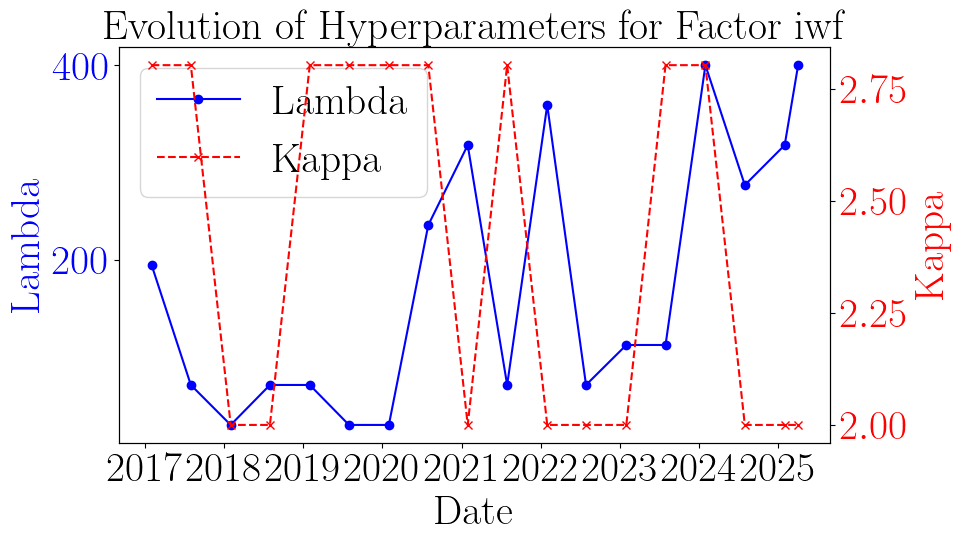

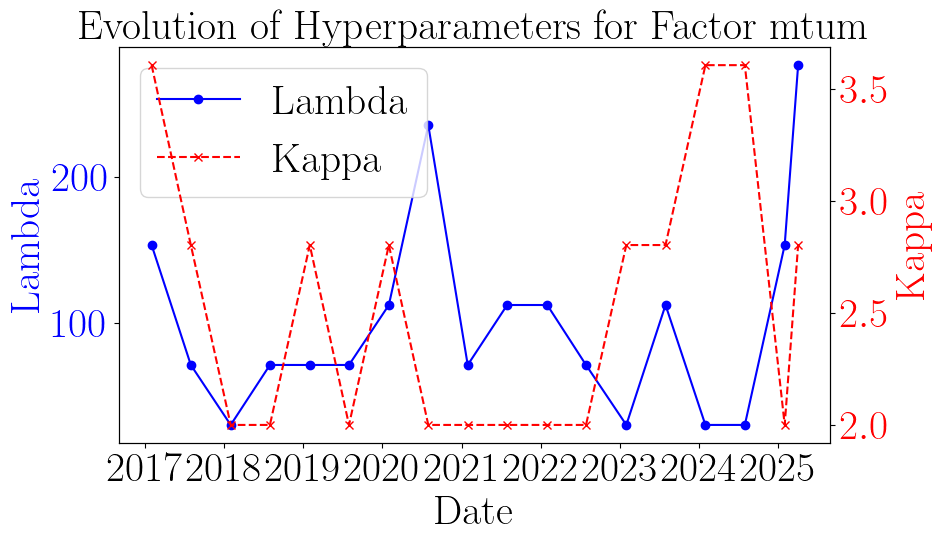

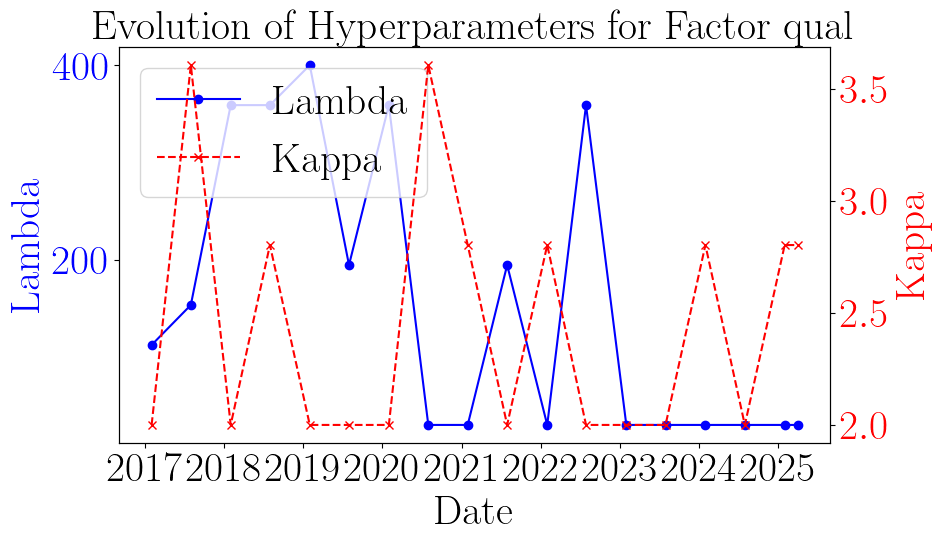

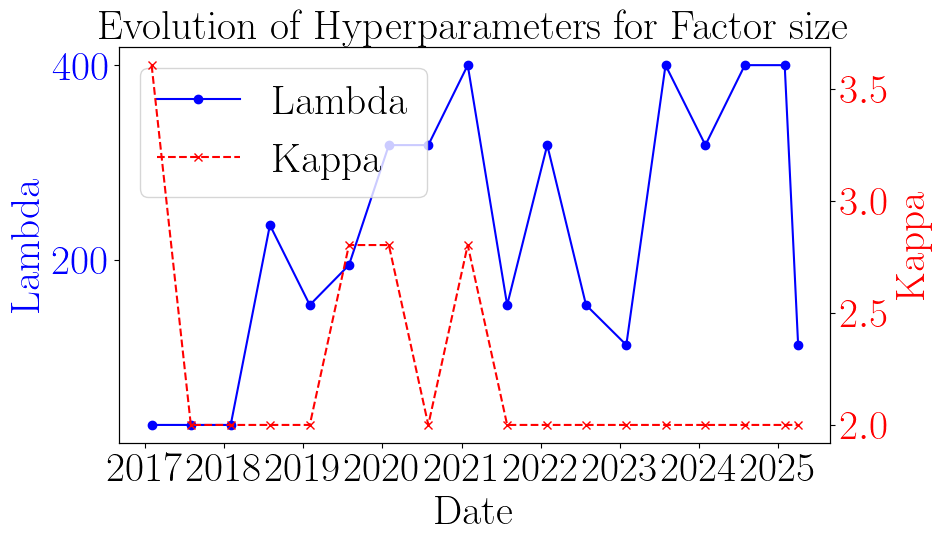

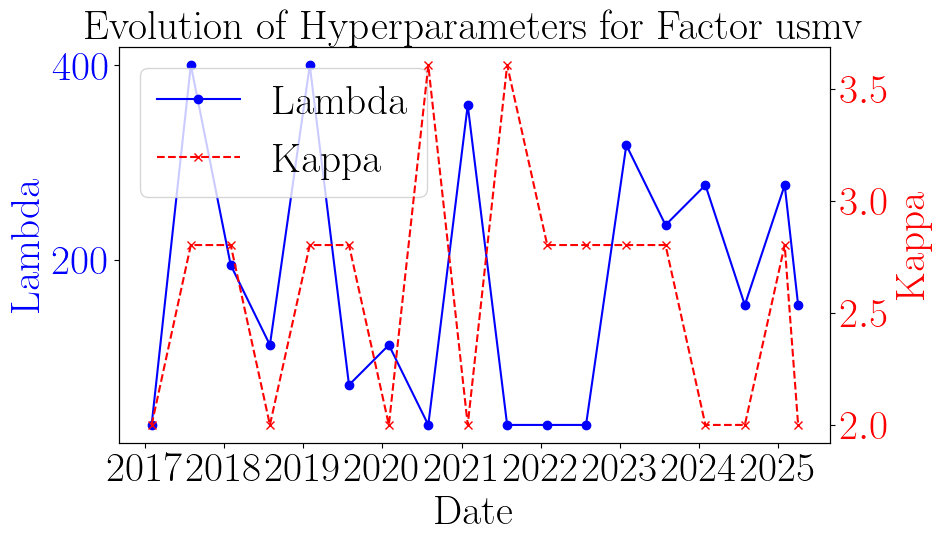

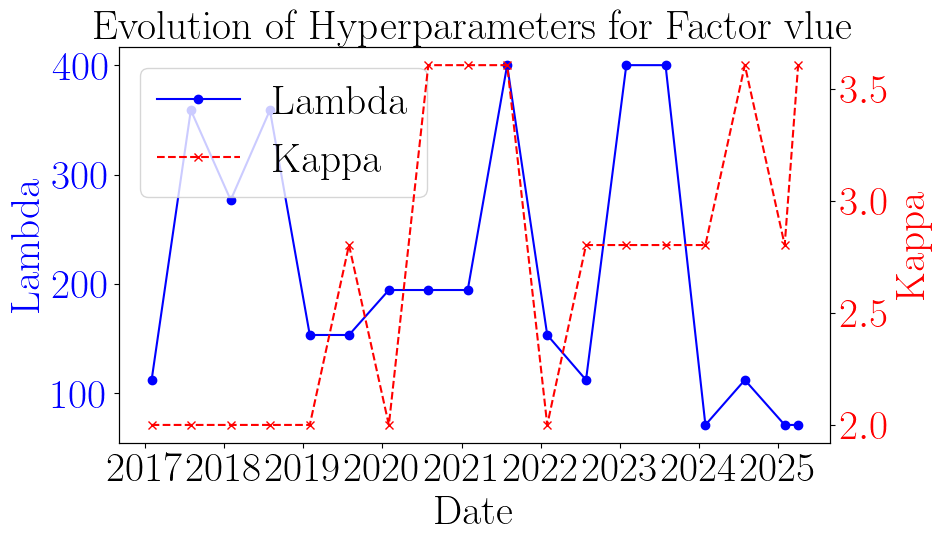

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hyperparameters_over_time(hyperparameter_history, factor):
    """
    Plot the evolution of hyperparameters (lambda and kappa) over time for a given factor.
    
    Parameters:
      hyperparameter_history (dict): Dictionary with factor keys and lists of hyperparameter history records.
      factor (str): The name of the factor to plot.
    """
    # Convert the list of history records to a DataFrame
    df = pd.DataFrame(hyperparameter_history[factor])
    
    # Ensure the 'date' column is in datetime format and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    
    # Set up the figure with dual y-axes for lambda and kappa
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot lambda on the primary y-axis (left)
    ax1.plot(df['date'], df['new_lambda'], marker='o', color='blue', label='Lambda')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Lambda', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis to plot kappa
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['new_kappa'], marker='x', linestyle='--', color='red', label='Kappa')
    ax2.set_ylabel('Kappa', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optional: Combine legends from both axes for clarity
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f"Evolution of Hyperparameters for Factor {factor}")
    plt.tight_layout()
    plt.show()

# Example usage: visualize hyperparameters for each factor
# Assume hyperparameter_history is a dictionary like:
# {
#   "factor1": [{"date": "2020-01-01", "old_lambda": ..., "new_lambda": ..., "old_kappa": ..., "new_kappa": ..., "sharpe": ...}, ...],
#   "factor2": [ ... ],
#   ...
# }
for fac in hyperparameter_history:
    plot_hyperparameters_over_time(hyperparameter_history, fac)
